In [32]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime 
pd.options.mode.chained_assignment = 'warn'  # default='warn'

In [33]:
scaler = StandardScaler(with_std=True, with_mean=True)

def filter_pca_data(df: pd.DataFrame, dropped_depths: list[int] = []):
    dropped_features = [
        'Unnamed: 0',
        'TIMESTAMP',
        'RECORD',
        'TIMESTAMP_DIFF',
        'Redox_error_flag_available',
        'log_redox(1)',
        'log_redox(2)',
        'log_redox(3)',
        'log_redox(4)',
        'log_redox(5)',
        'neg_log(1)',
        'neg_log(2)',
        'neg_log(3)',
        'neg_log(4)',
        'neg_log(5)',
        'Temp_T21_Avg(1)',
        'Temp_T21_Avg(2)',
        'Temp_T21_Avg(3)',
        'Temp_T21_Avg(4)',
        'Temp_T21_Avg(5)',
        'Redox_error_flag(1)',
        'Redox_error_flag(2)',
        'Redox_error_flag(3)',
        'Redox_error_flag(4)',
        'Redox_error_flag(5)',
        'CCVWC_Avg(1)',
        'CCVWC_Avg(2)',
        'CCVWC_Avg(3)',
        'CCVWC_Avg(4)',
        'CCVWC_Avg(5)',
        'shf_plate_Avg',
        'shf_multiplier',
        'shf_htr_resstnc',
        'shfp_wrnng_flg',
        'btt_wrnng_flg',
        'BatterymV_Min',
        'pit_number'
    ]
    for d in dropped_depths:
        dropped_features.extend([
            f'Redox_Avg({d})',
            f'EC_Avg({d})',
            f'Temp_T12_Avg({d})',
            f'Matric_potential_Avg({d})',
            f'WC{d}',
            f'Redox_Avg({d})_sigma_f'
            f'Redox_Avg({d})_sigma_b'
        ])
    pca_data = df.loc[:, ~df.columns.isin(dropped_features)]
    return pca_data
    

def getDistanceByPoint(data: pd.DataFrame, model: KMeans):
    cluster_centers_per_label = pd.DataFrame(model.cluster_centers_).loc[model.labels_].reset_index().drop('index', axis=1)
    return pd.DataFrame(np.linalg.norm(cluster_centers_per_label - data, axis=1))

def get_pca_scores(pca_data, n_components):
    scaled = scaler.fit_transform(pca_data)
    pca = PCA(n_components)
    return pca.fit_transform(scaled)

def k_means(data, n_clusters):
    kmeans = KMeans(n_clusters, n_init=10).fit(data)
    return kmeans.predict(data), kmeans

def pca_kmeans(pca_data, full_data, n_clusters, n_components, outliers_fraction):
    pca_scores = get_pca_scores(pca_data, n_components)
    scaled_pca_scores = scaler.fit_transform(pca_scores)
    data = pd.DataFrame(scaled_pca_scores)

    clusters, model = k_means(data, n_clusters)
    distance = getDistanceByPoint(data, model)
    outlier_num = int(outliers_fraction * len(distance))
    threshold = distance.nlargest(outlier_num, columns=[0]).min()
    is_anomaly = (distance >= threshold)
    full_data = full_data.assign(cluster=clusters, anomaly=is_anomaly.to_numpy())
    return full_data

def get_acc_metric_dfs(df: pd.DataFrame):
    # true_positives = df.query('(`Redox_error_flag(1)` == True | `Redox_error_flag(2)` == True | `Redox_error_flag(3)` == True | `Redox_error_flag(4)` == True | `Redox_error_flag(5)` == True) & (anomaly == True)')
    # false_positives = df.query('(`Redox_error_flag(1)` == False & `Redox_error_flag(2)` == False & `Redox_error_flag(3)` == False & `Redox_error_flag(4)` == False & `Redox_error_flag(5)` == False) & (anomaly == True)')
    true_positives = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True)) & (df['anomaly'] == True)]
    false_positives = df[((df['Redox_error_flag(1)'] == False) & (df['Redox_error_flag(2)'] == False) & (df['Redox_error_flag(3)'] == False) & (df['Redox_error_flag(4)'] == False) & (df['Redox_error_flag(5)'] == False)) & (df['anomaly'] == True)]
    true_negatives = df[((df['Redox_error_flag(1)'] == False) & (df['Redox_error_flag(2)'] == False) & (df['Redox_error_flag(3)'] == False) & (df['Redox_error_flag(4)'] == False) & (df['Redox_error_flag(5)'] == False)) & (df['anomaly'] == False)]
    false_negatives = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True)) & (df['anomaly'] == False)]
    return (true_positives, true_negatives, false_positives, false_negatives)

def get_ind_depth_acc_metric_dfs(df: pd.DataFrame, pit: int):
    # true_positives = df.query('(`Redox_error_flag(1)` == True | `Redox_error_flag(2)` == True | `Redox_error_flag(3)` == True | `Redox_error_flag(4)` == True | `Redox_error_flag(5)` == True) & (anomaly == True)')
    # false_positives = df.query('(`Redox_error_flag(1)` == False & `Redox_error_flag(2)` == False & `Redox_error_flag(3)` == False & `Redox_error_flag(4)` == False & `Redox_error_flag(5)` == False) & (anomaly == True)')
    true_positives = df[(df[f'Redox_error_flag({pit})'] == True) & (df['anomaly'] == True)]
    false_positives = df[(df[f'Redox_error_flag({pit})'] == False) & (df['anomaly'] == True)]
    true_negatives = df[(df[f'Redox_error_flag({pit})'] == False) & (df['anomaly'] == False)]
    false_negatives = df[(df[f'Redox_error_flag({pit})'] == True) & (df['anomaly'] == False)]
    return (true_positives, true_negatives, false_positives, false_negatives)

def get_acc_metrics(acc_metric_dfs: tuple[pd.DataFrame]):
    true_positives, true_negatives, false_positives, false_negatives = acc_metric_dfs
    acc = (true_positives.shape[0] + true_negatives.shape[0]) / (true_positives.shape[0] + true_negatives.shape[0] + false_positives.shape[0] + false_negatives.shape[0])
    prec = true_positives.shape[0] / (true_positives.shape[0] + false_positives.shape[0])
    rec = true_positives.shape[0] / (true_positives.shape[0] + false_negatives.shape[0])
    return (acc, prec, rec)

In [34]:
all_training_data = pd.read_csv('../../Data/Training/Raw_training_data_full.csv', parse_dates=['TIMESTAMP'])
training_data_2022 = all_training_data.loc[all_training_data['TIMESTAMP'] < datetime(2023, 1,1, 0, 0, 0), :]
training_data_2023 = all_training_data.loc[all_training_data['TIMESTAMP'] >= datetime(2023, 1,1, 0, 0, 0), :]

/tmp/ipykernel_4221/575840907.py:1: DtypeWarning: Columns (54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  all_training_data = pd.read_csv('../../Data/Training/Raw_training_data_full.csv', parse_dates=['TIMESTAMP'])


In [35]:
pca_data = filter_pca_data(all_training_data)
scaler = StandardScaler(with_std=True, with_mean=True)
scaled = scaler.fit_transform(pca_data)
pca = PCA()
pca.fit(scaled)
scores = pca.transform(scaled)

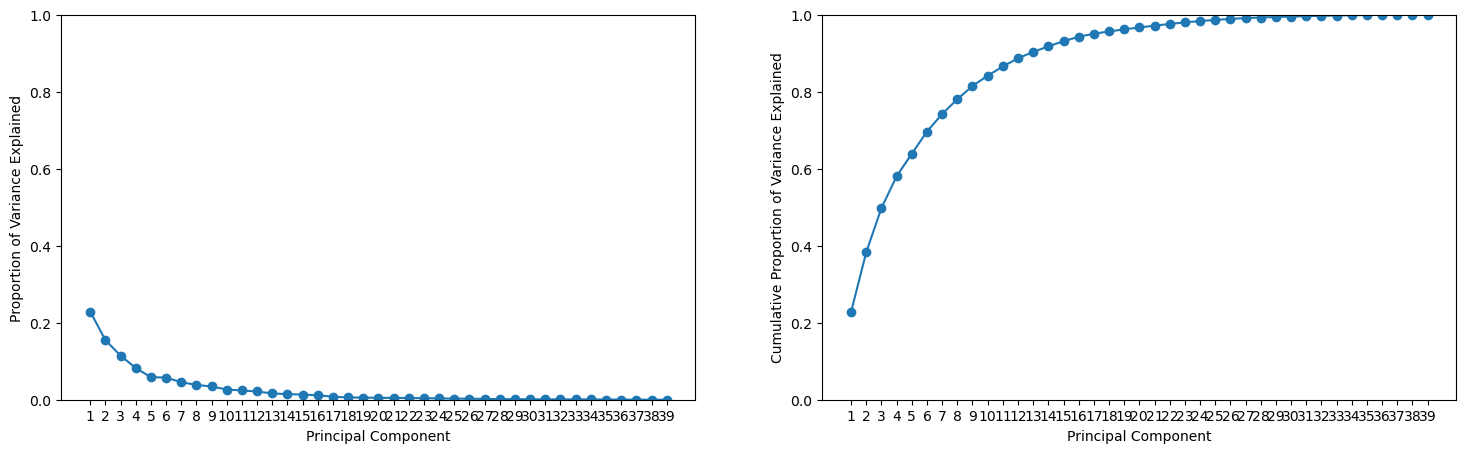

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.set_size_inches((18,5))
ticks = np.arange(pca.n_components_)+1
ax = axes[0]
ax.plot(ticks, pca.explained_variance_ratio_, marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_ylim([0,1])
ax.set_xticks(ticks)
ax = axes[1]
ax.plot(ticks, pca.explained_variance_ratio_.cumsum(), marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion of Variance Explained')
ax.set_ylim([0, 1])
ax.set_xticks(ticks)

## 2022 whole data

In [37]:
outliers_fraction = 0.37
pca_data = filter_pca_data(training_data_2022)

for components in range(5,8):
    for clusters in range(2,8):
        anomaly_data = pca_kmeans(pca_data, training_data_2022, clusters, components, outliers_fraction)
        acc, prec, rec = get_acc_metrics(get_acc_metric_dfs(anomaly_data))
        print(f'Components: {components}, clusters: {clusters}, acc: {acc}, precision: {prec}, recall: {rec}')


Components: 5, clusters: 2, acc: 0.7221345661022059, precision: 0.636511652941493, recall: 0.6258003915965498
Components: 5, clusters: 3, acc: 0.672559167881011, precision: 0.5701329457990204, recall: 0.560538709848124
Components: 5, clusters: 4, acc: 0.7658911612481785, precision: 0.6950993056676893, recall: 0.6834021273217971
Components: 5, clusters: 5, acc: 0.7825737400130647, precision: 0.7174363528715216, recall: 0.7053632851775414
Components: 5, clusters: 6, acc: 0.651525048992513, precision: 0.5423374507940817, recall: 0.5285759644387998
Components: 5, clusters: 7, acc: 0.6453494799256319, precision: 0.5340012761509116, recall: 0.520373604275811
Components: 6, clusters: 2, acc: 0.7270991407466961, precision: 0.6431589428925131, recall: 0.6323358205006085
Components: 6, clusters: 3, acc: 0.6744083211898899, precision: 0.5726088594649873, recall: 0.5629729586706884
Components: 6, clusters: 4, acc: 0.7698206120295462, precision: 0.7003606222078691, recall: 0.6885749060697465
Compon

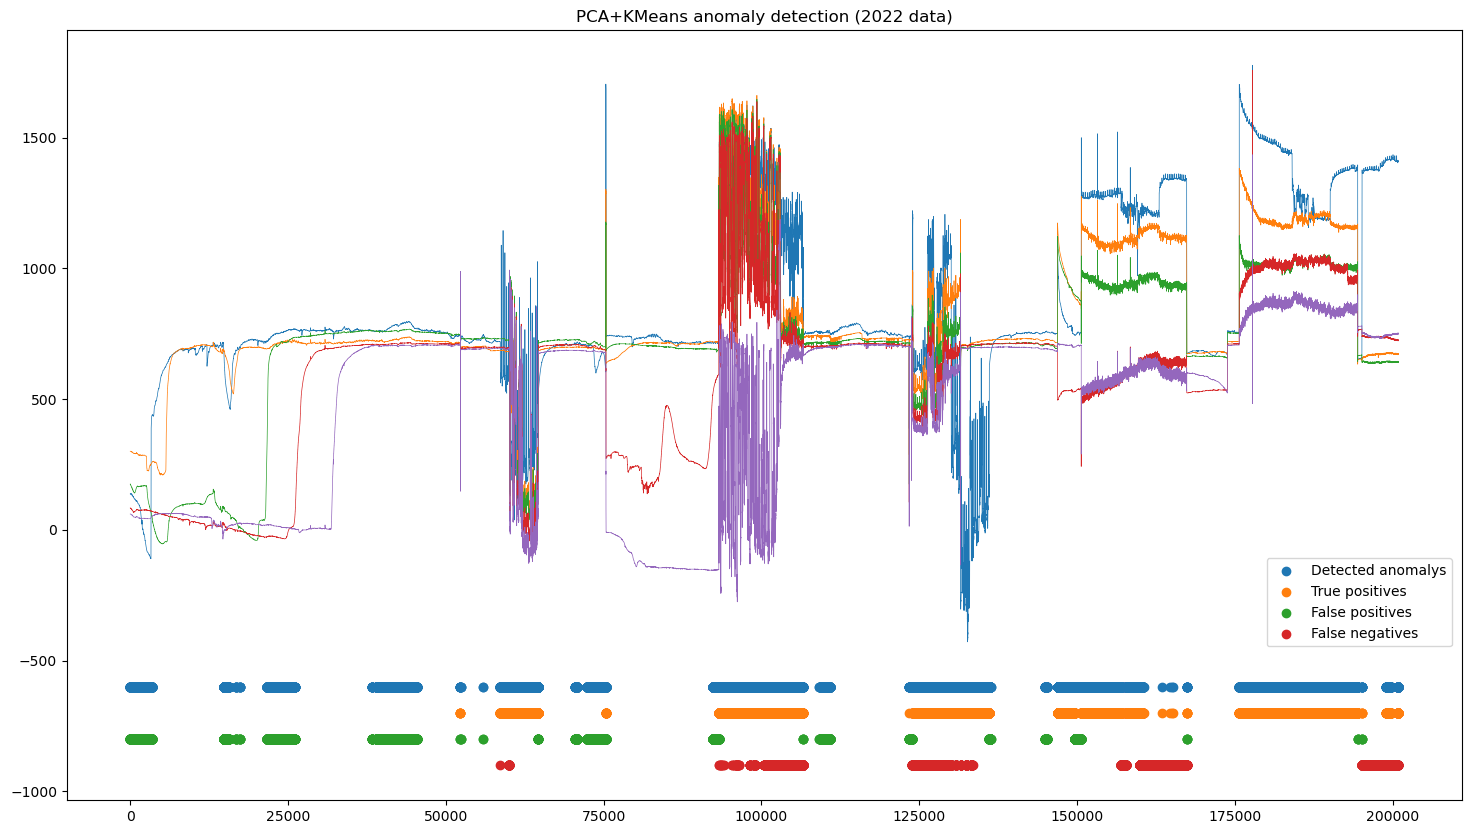

In [38]:
n_clusters = 5
pca_components = 5
outliers_fraction = 0.37
pca_data = filter_pca_data(training_data_2022)

anomaly_data = pca_kmeans(pca_data, training_data_2022, n_clusters, pca_components, outliers_fraction)
true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)

plt.figure(figsize=(18,10))
plt.plot(anomaly_data.index, anomaly_data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5)
plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
plt.title('PCA+KMeans anomaly detection (2022 data)')
plt.legend(loc=(0.86,0.2))

## Visualizing clusters

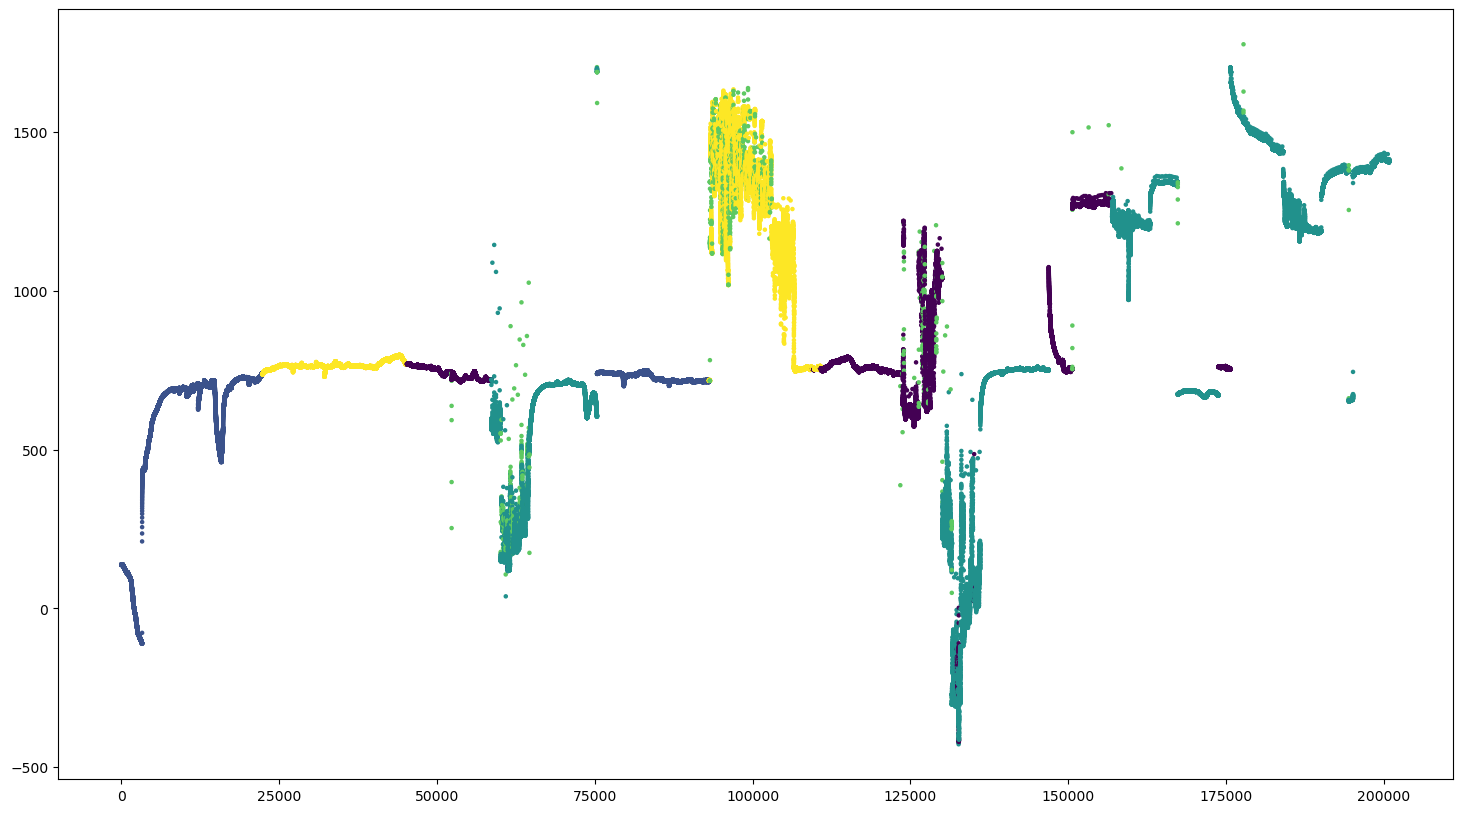

In [39]:
plt.figure(figsize=(18,10))
plt.scatter(anomaly_data.index, anomaly_data['Redox_Avg(1)'], s=5, c=anomaly_data['cluster'])

In [40]:
outliers_fraction = 0.10
data = training_data_2022[training_data_2022['pit_number'] == 4]
pca_data = filter_pca_data(data)

for components in range(5,8):
    for clusters in range(2,8):
        anomaly_data = pca_kmeans(pca_data, data, clusters, components, outliers_fraction)
        acc, prec, rec = get_acc_metrics(get_acc_metric_dfs(anomaly_data))
        print(f'Components: {components}, clusters: {clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

Components: 5, clusters: 2, acc: 0.13336243155305136, precision: 0.997046880767811, recall: 0.11009211706203635
Components: 5, clusters: 3, acc: 0.13336243155305136, precision: 0.997046880767811, recall: 0.11009211706203635
Components: 5, clusters: 4, acc: 0.13336243155305136, precision: 0.997046880767811, recall: 0.11009211706203635
Components: 5, clusters: 5, acc: 0.13328307277200221, precision: 0.9966777408637874, recall: 0.11005135730007337
Components: 5, clusters: 6, acc: 0.13328307277200221, precision: 0.9966777408637874, recall: 0.11005135730007337
Components: 5, clusters: 7, acc: 0.13324339338147767, precision: 0.9966765140324964, recall: 0.11001059753811038
Components: 6, clusters: 2, acc: 0.13336243155305136, precision: 0.997046880767811, recall: 0.11009211706203635
Components: 6, clusters: 3, acc: 0.13336243155305136, precision: 0.997046880767811, recall: 0.11009211706203635
Components: 6, clusters: 4, acc: 0.12149829378620744, precision: 0.9449814126394052, recall: 0.103611

In [45]:
for pit in range(1,5):
    df = training_data_2022[training_data_2022['pit_number'] == pit]
    errors = df[((df['Redox_error_flag(1)'] == True) | (df['Redox_error_flag(2)'] == True) | (df['Redox_error_flag(3)'] == True) | (df['Redox_error_flag(4)'] == True) | (df['Redox_error_flag(5)'] == True))].shape[0]
    print(errors)
    print(errors / df.shape[0])

6037
0.08012901341898833
25607
0.357824574151447
19410
0.7214540588760036
24534
0.9053804708834601


## 2022 per pit

Pit: 1, components: 6, clusters: 7, acc: 0.8525769501333935, precision: 0.33176267586939207, recall: 0.8280602948484347
Pit: 2, components: 6, clusters: 7, acc: 0.7530707209032601, precision: 0.7772498602571268, recall: 0.4344124653415082
Pit: 3, components: 6, clusters: 7, acc: 0.477921498661909, precision: 0.9985130111524163, recall: 0.27676455435342606
Pit: 4, components: 6, clusters: 7, acc: 0.23942544242520436, precision: 0.9972201630837657, recall: 0.2193282791228499


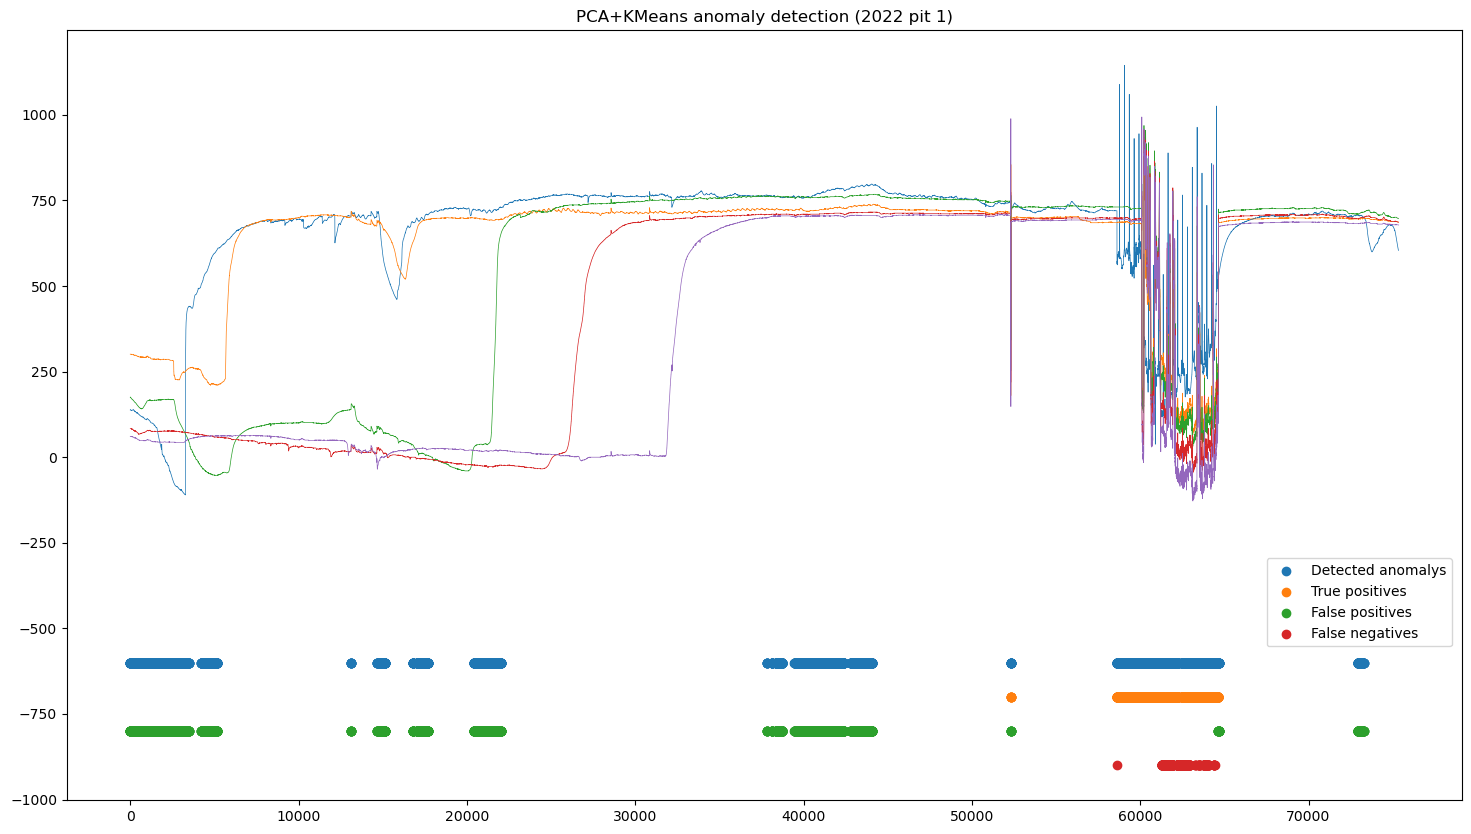

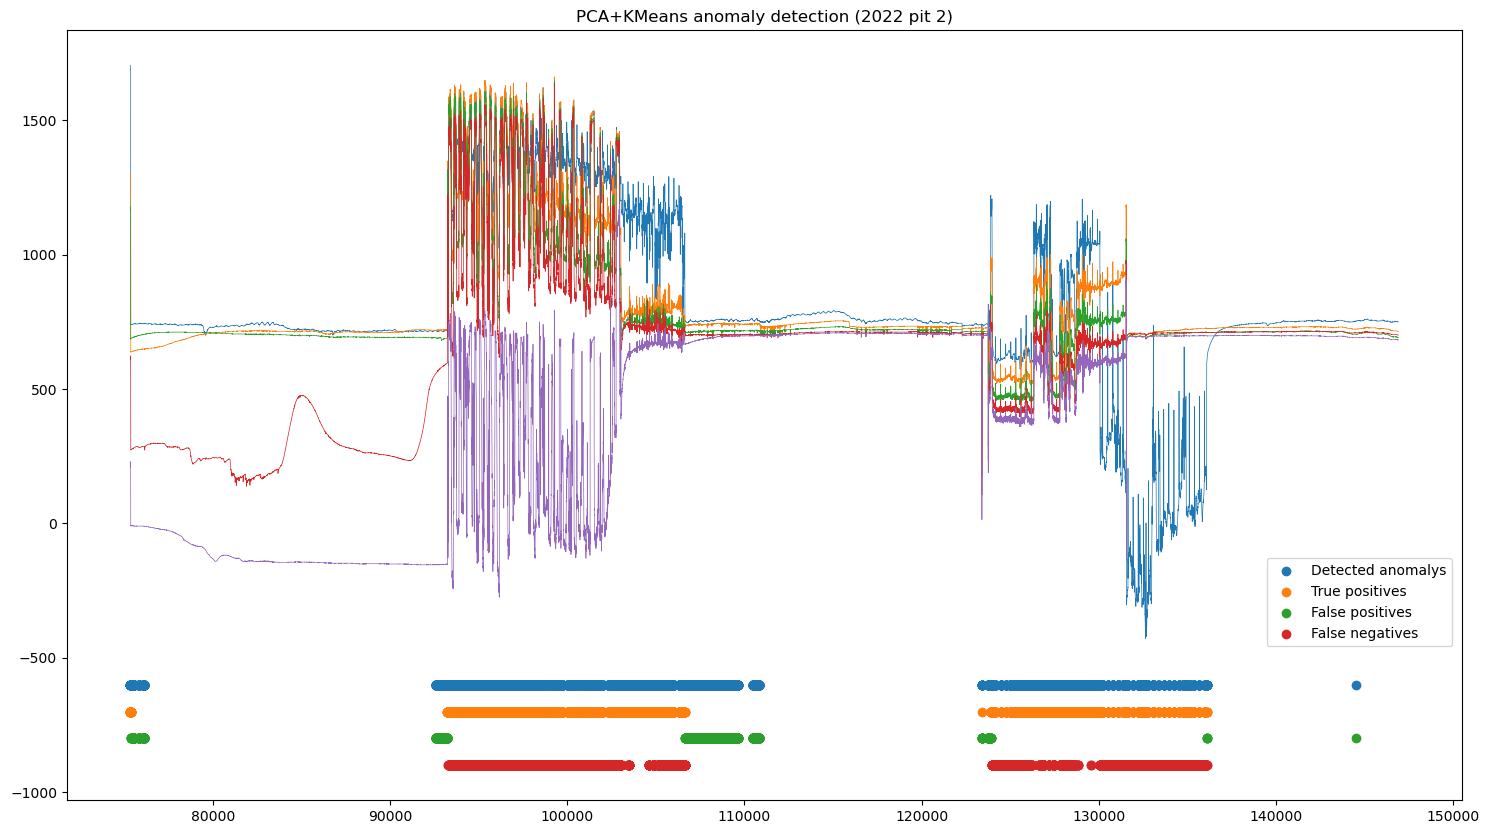

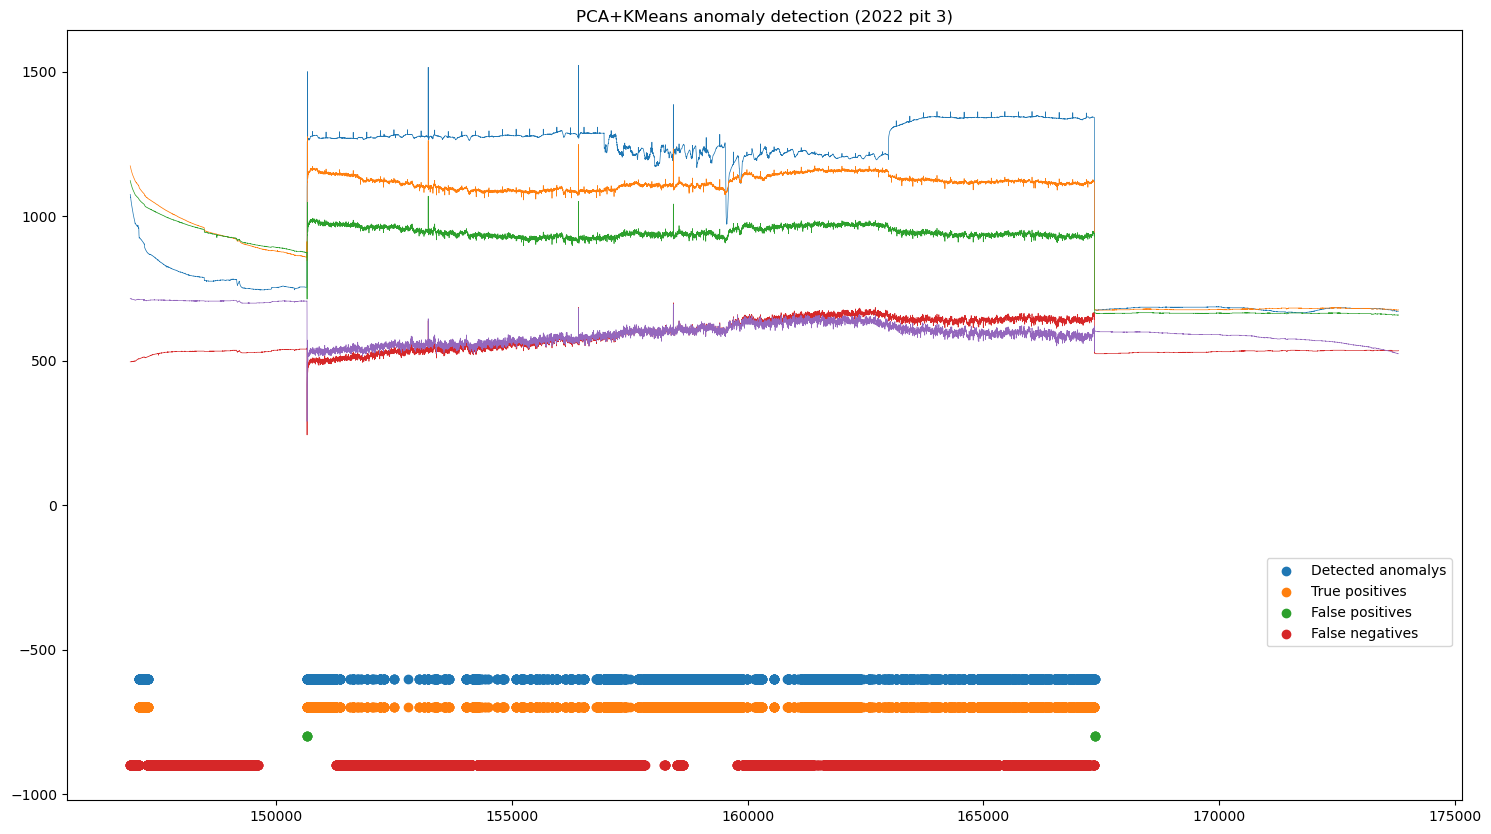

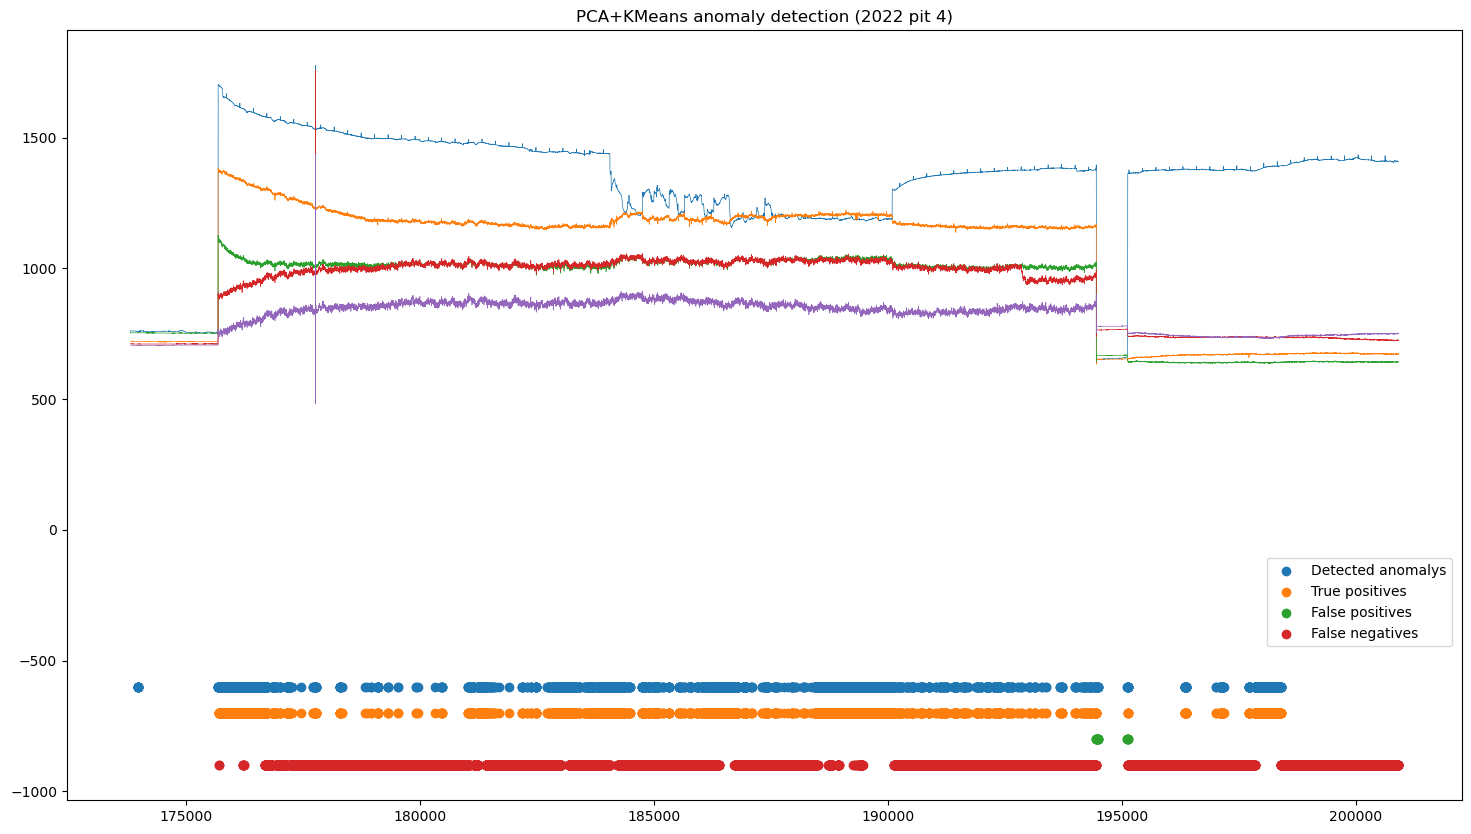

In [47]:
for pit in range(1,5):
    data = training_data_2022[training_data_2022['pit_number'] == pit]
    n_clusters = 7
    pca_components = 6
    outliers_fraction = 0.20
    pca_data = filter_pca_data(data)

    anomaly_data = pca_kmeans(pca_data, data, n_clusters, pca_components, outliers_fraction)
    true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)
    acc, prec, rec = get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives))
    print(f'Pit: {pit}, components: {pca_components}, clusters: {n_clusters}, acc: {acc}, precision: {prec}, recall: {rec}')

    plt.figure(figsize=(18,10))
    plt.plot(anomaly_data.index, anomaly_data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5)
    plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
    plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
    plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
    plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
    plt.legend(loc=(0.86,0.2))
    plt.title(f'PCA+KMeans anomaly detection (2022 pit {pit})')

## 2022 depth specific

(0.6675393196321793, 0.6747635639621702, 0.1852292136366742)
(0.7020400984875131, 0.5559482329517172, 0.18147696807214234)
(0.7437817195115823, 0.7671976107516177, 0.2497002883711888)
(0.8401085372594342, 0.7594741297744136, 0.36104732369025355)
(0.8380282397869454, 0.2880537580886013, 0.24399190488236783)


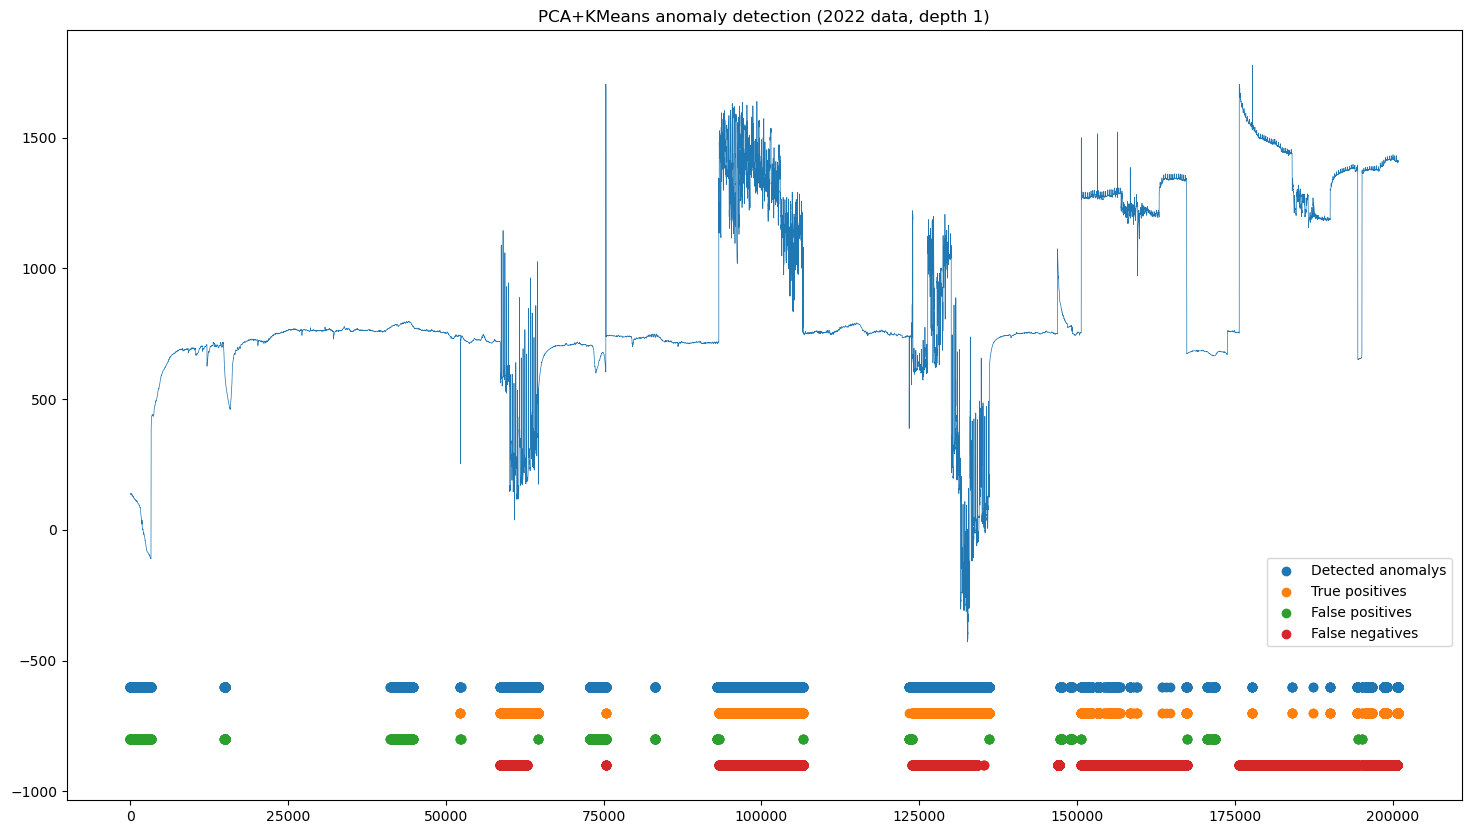

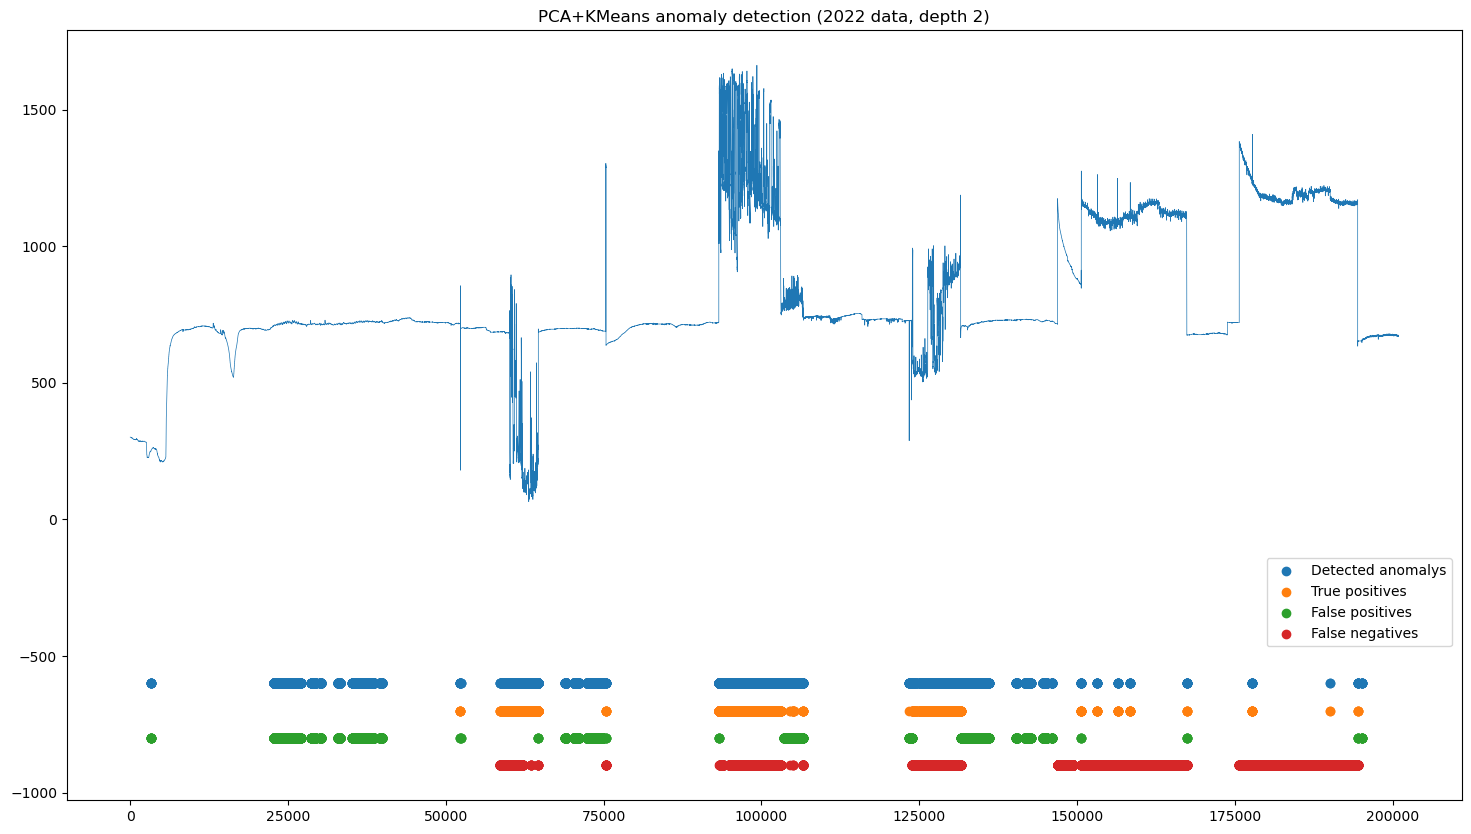

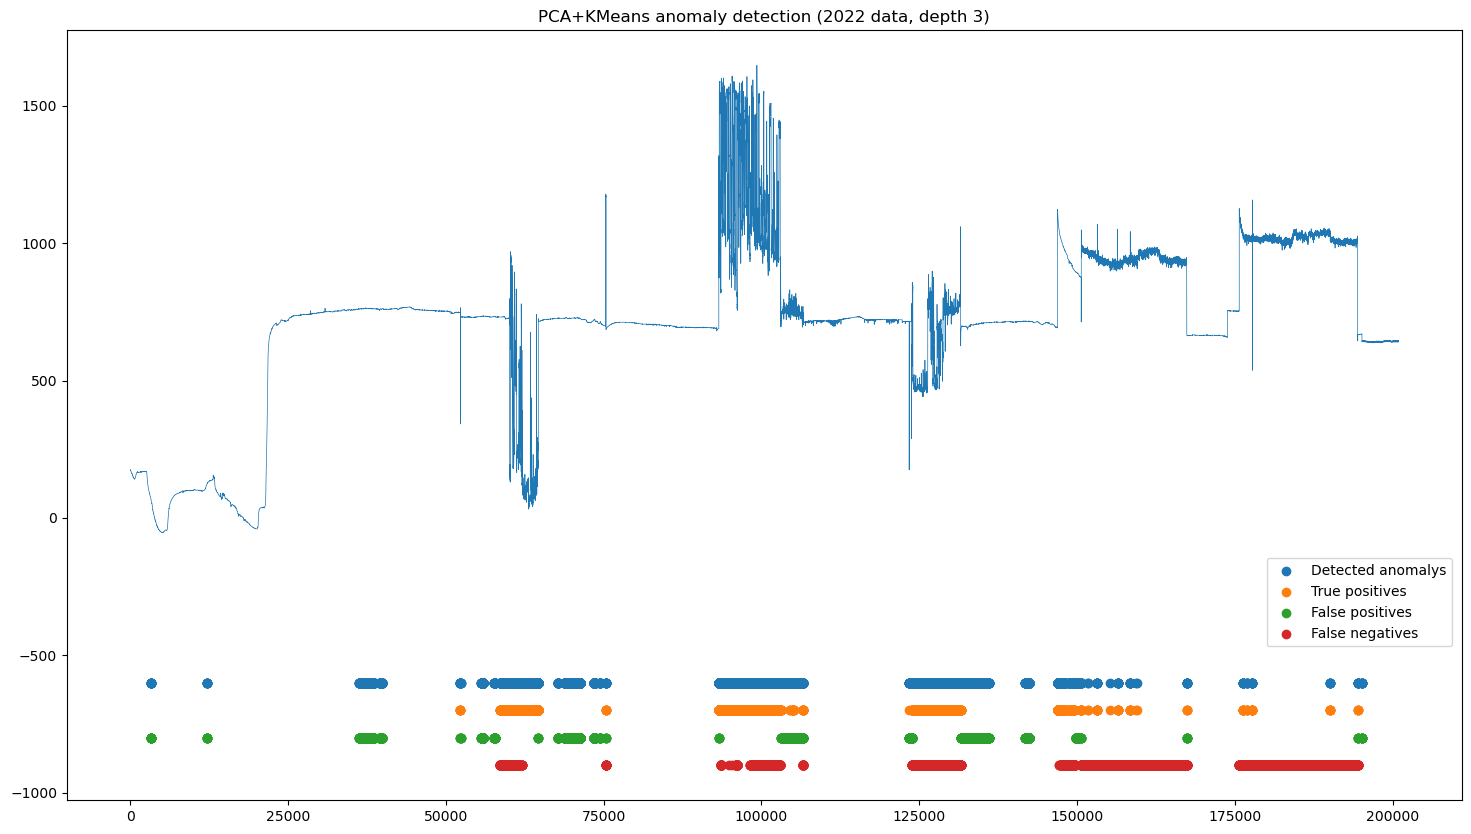

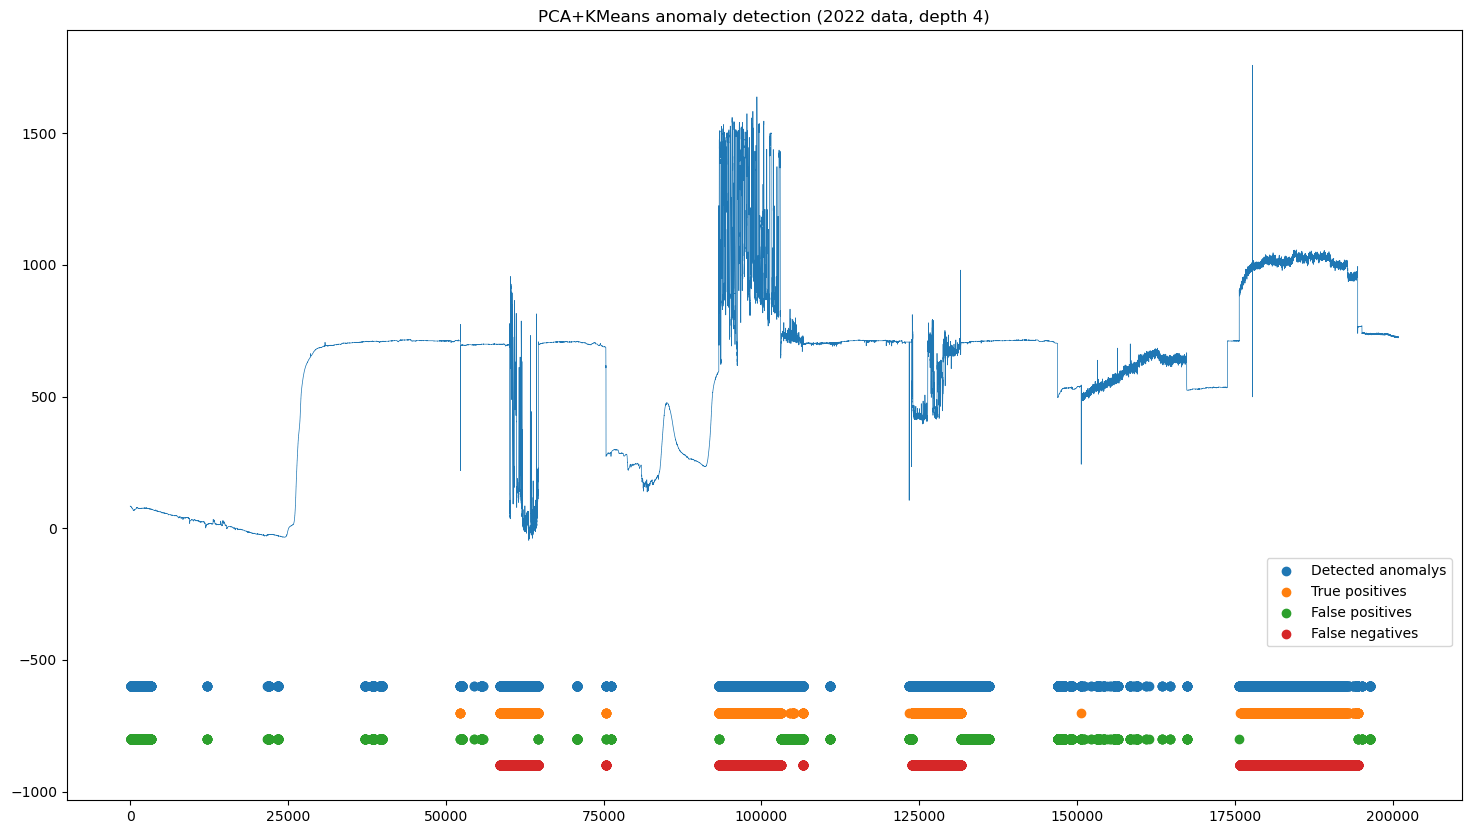

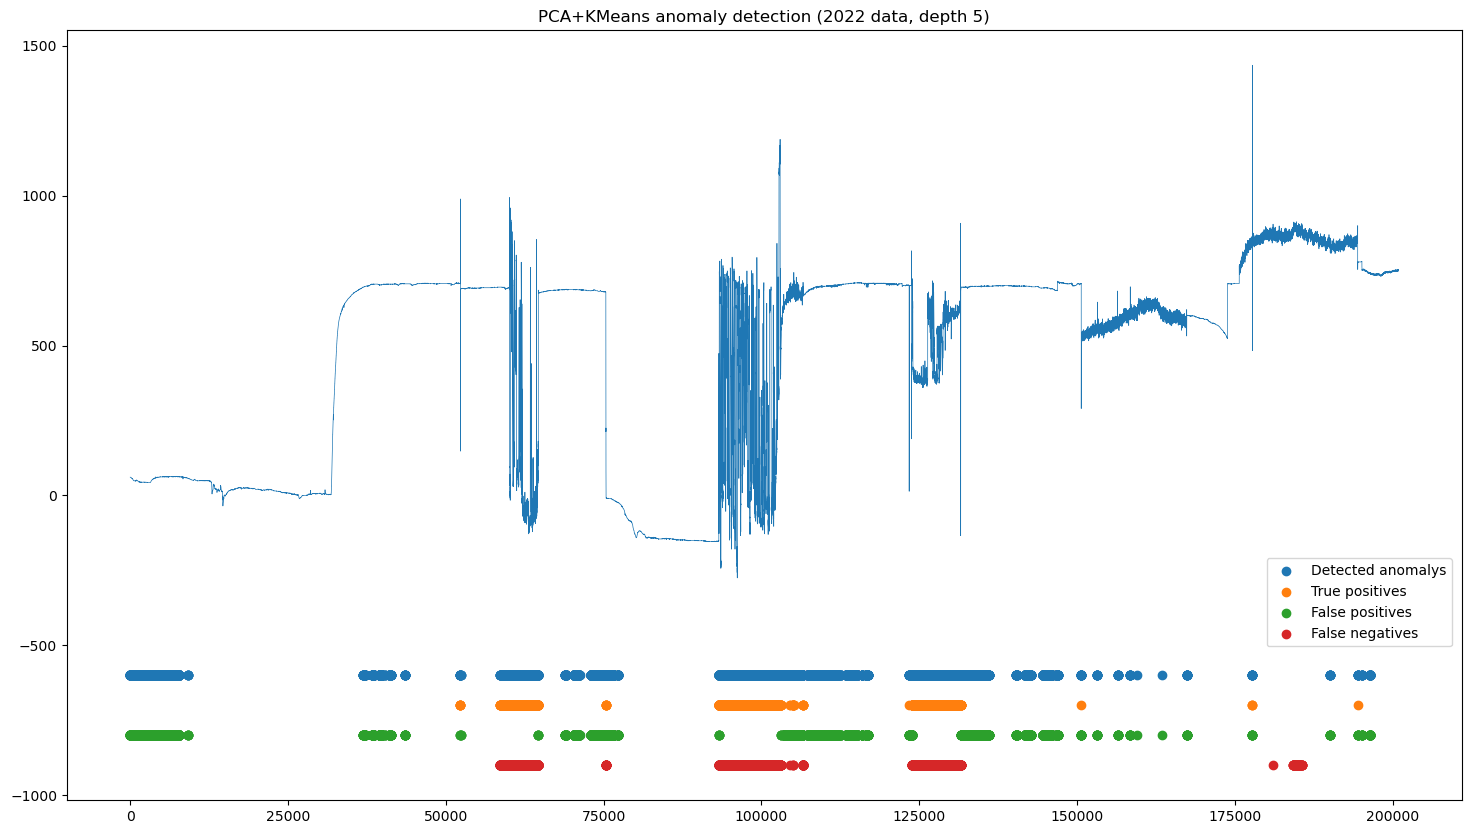

In [42]:
n_clusters = 5
pca_components = 5
outliers_fraction = 0.10

for d in range(1,6):
    depths = [1,2,3,4,5]
    depths.remove(d)
    pca_data = filter_pca_data(training_data_2022, depths)

    anomaly_data = pca_kmeans(pca_data, training_data_2022, n_clusters, pca_components, outliers_fraction)
    true_positives, true_negatives, false_positives, false_negatives = get_ind_depth_acc_metric_dfs(anomaly_data, d)
    print(get_acc_metrics((true_positives, true_negatives, false_positives, false_negatives)))

    plt.figure(figsize=(18,10))
    plt.plot(anomaly_data.index, anomaly_data[[f'Redox_Avg({d})']], linewidth=0.5)
    plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-600, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys')
    plt.scatter(true_positives.index, np.repeat(-700, true_positives.shape[0]), label='True positives')
    plt.scatter(false_positives.index, np.repeat(-800, false_positives.shape[0]), label='False positives')
    plt.scatter(false_negatives.index, np.repeat(-900, false_negatives.shape[0]), label='False negatives')
    plt.title(f'PCA+KMeans anomaly detection (2022 data, depth {d})')
    plt.legend(loc=(0.86,0.2))

## 2023

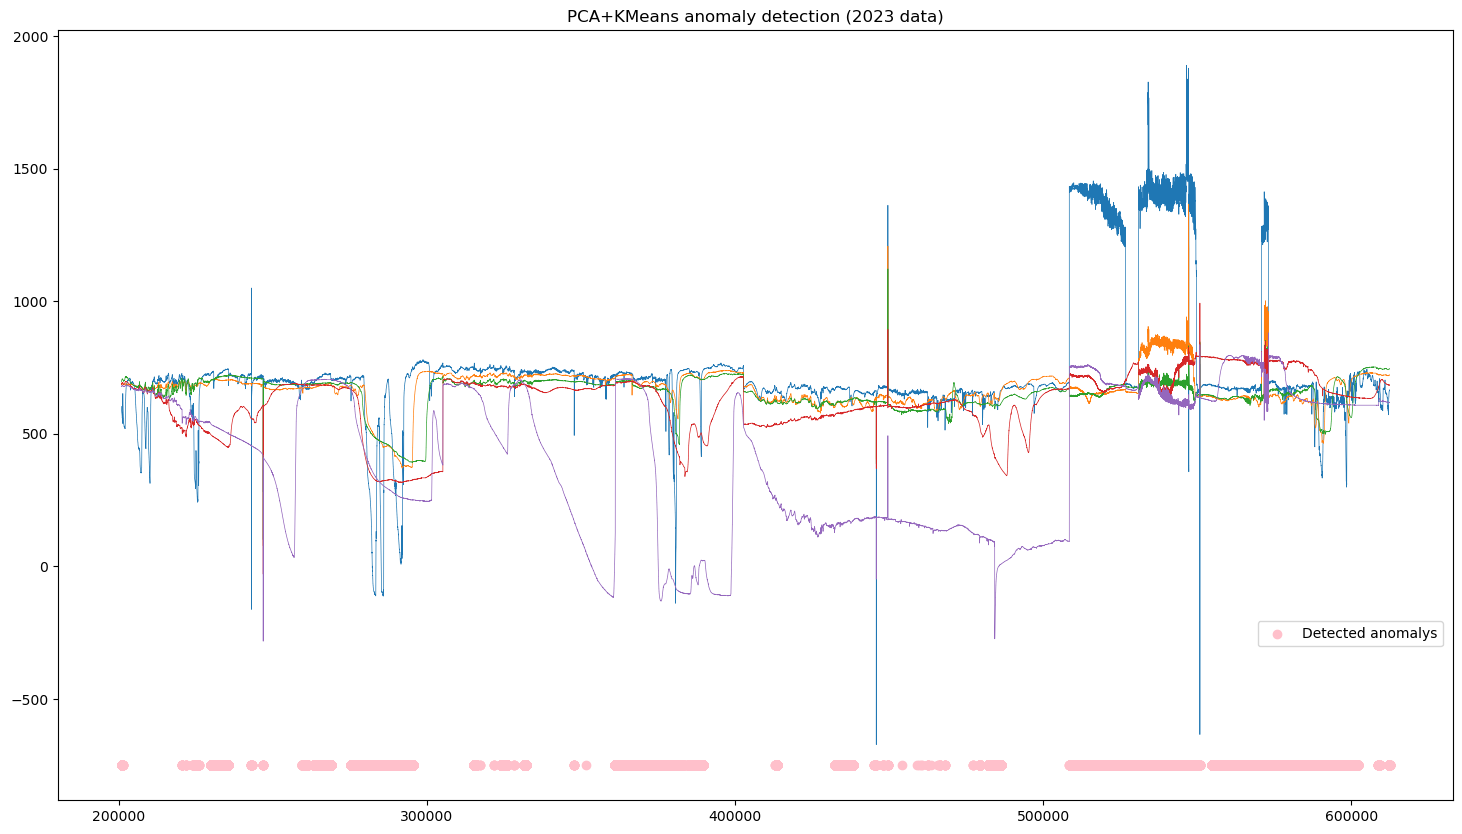

In [43]:
n_clusters = 5
pca_components = 5
outliers_fraction = 0.37
pca_data = filter_pca_data(training_data_2023)

anomaly_data = pca_kmeans(pca_data, training_data_2023, n_clusters, pca_components, outliers_fraction)
true_positives, true_negatives, false_positives, false_negatives = get_acc_metric_dfs(anomaly_data)

plt.figure(figsize=(18,10))
plt.plot(anomaly_data.index, anomaly_data[['Redox_Avg(1)', 'Redox_Avg(2)', 'Redox_Avg(3)', 'Redox_Avg(4)', 'Redox_Avg(5)']], linewidth=0.5)
plt.scatter(anomaly_data[anomaly_data['anomaly'] == True].index, np.repeat(-750, anomaly_data[anomaly_data['anomaly'] == True].shape[0]), label='Detected anomalys', c='pink')
plt.title('PCA+KMeans anomaly detection (2023 data)')
plt.legend(loc=(0.86,0.2))